### Classifying a Kaggle dataset using PyTorch
#### CIFAR-10

In [11]:
import os
import torch
import random
import cupy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.models as models
from IPython.display import clear_output
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

seed = 300900
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.set_default_device("cuda:0")
    torch.cuda.set_device("cuda:0")
    device = "cuda:0"

In [12]:
class WaldoDataset(Dataset): #Our dataset class
    def __init__(self):
        self.waldo_folder = "Data/Waldo"
        self.notWaldo_folder = "Data/NotWaldo"
        self.image_files = [(os.path.join(self.waldo_folder, f), 1) for f in os.listdir(self.waldo_folder)] + [(os.path.join(self.notWaldo_folder, f), 0) for f in os.listdir(self.notWaldo_folder)]

    def __len__(self) -> int:
        return len(self.image_files)
    
    def __getitem__(self, idx) -> Image:
        image = Image.open(self.image_files[idx][0])

        to_tensor = transforms.Compose([
            transforms.RandomHorizontalFlip(),          # Random horizontal flip
            transforms.RandomVerticalFlip(),            # Random vertical flip
            transforms.RandomRotation(30),              # Random rotation within 30 degrees
            transforms.RandomGrayscale(p=0.2),          # Convert image to grayscale with a probability of 20%
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # Random perspective transformation
            transforms.RandomResizedCrop(size=64, scale=(0.95, 1.0)),  # Random resized crop
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),  # Random Gaussian blur
            transforms.ToTensor(),                      # Convert to tensor
            transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])  # Normalize with ImageNet means and stds
        ])
        
        return to_tensor(image), self.image_files[idx][1]
    
    def getLabel(self, idx):
        return self.image_files[idx][1]

In [13]:
class WaldoRecognizer(nn.Module):
    def __init__(self, **kwargs):
        super(WaldoRecognizer, self).__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.45),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Dropout(p=0.45),
            nn.Linear(256, 2)
        )

        # Apply Xavier initialization
        self._initialize_weights()

    def forward(self, x):
        return self.network(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [14]:
def show_images(images):
    fig, axes = plt.subplots(1, 5, figsize=(15,6))
    to_image = transforms.ToPILImage()
    
    for i in range(len(images)):
        axes[i].imshow(to_image(images[i][0]))
        axes[i].set_title(f"Waldo : {images[i][1]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [15]:
dataset = WaldoDataset()

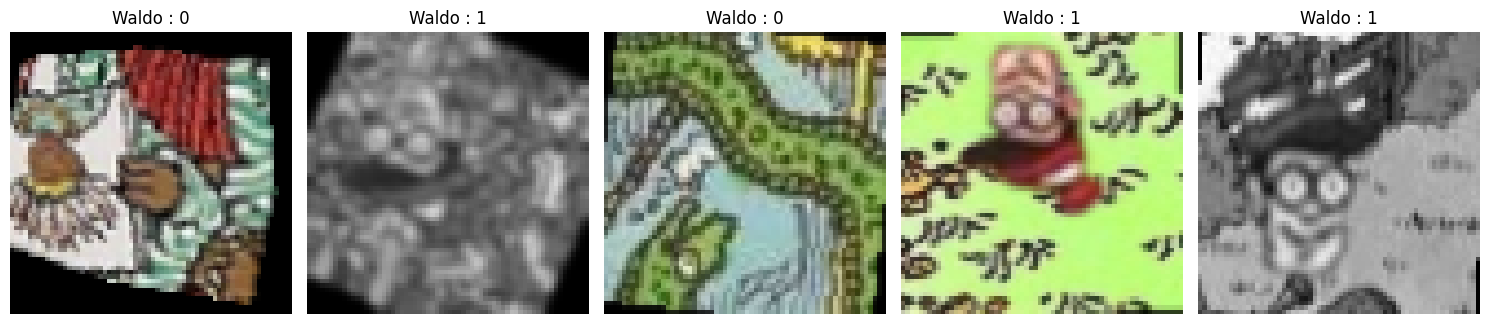

In [16]:
random_array = np.random.randint(0, len(dataset), 5, dtype='int')
images = [dataset[int(i)] for i in random_array]
show_images(images)

In [17]:
# Splitting indices for train, validation, and test sets
batch_size =  2 ** 6
print(batch_size)

train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=seed)
train_indices, valid_indices = train_test_split(train_indices, test_size=0.4, random_state=seed)

# Creating SubsetRandomSampler instances for train, validation, and test sets
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Creating DataLoader instances for train, validation, and test sets using the samplers
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

64


In [22]:
for t in test_loader:
    print(t)

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 

KeyboardInterrupt: 

In [ ]:
network = WaldoRecognizer().to(device)
loss_function = nn.CrossEntropyLoss()

In [ ]:
#Defining early stopping

patience = 5  # Number of epochs to wait before stopping if validation loss doesn't improve
counter = 0  # Counter to keep track of epochs without improvement
best_val_loss = float('inf')  # Variable to store the best validation loss

In [ ]:
lr = 1e-3
weight_decay = 1e-4
# momentum = 0.95 # Used with SGD

optimizer = optim.Adam(network.parameters(), lr=lr, weight_decay=weight_decay)

step_size = 2
gamma = 0.75
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

epochs = 20
train_losses = []
train_accuracies = []
for epoch in range(epochs):
    
    network.train()  # Set the network to training mode
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training") as t:
        for data, target in t:
            total = 0
            correct = 0
            data = data.to(device)
            target_tensor = target.clone().detach()
            optimizer.zero_grad()  # Zero the gradients
            output = network(data)  # Forward pass
            loss = loss_function(output, target_tensor)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters

            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            train_losses.append(loss.item())

            accuracy = (correct / total)
            train_accuracies.append(accuracy)

            t.set_postfix(current_loss=loss.item(), accuracy=accuracy)
            
            # Clear the output of the cell
            clear_output(wait=True)
            fig, ax1 = plt.subplots()

            color = 'tab:red'
            ax1.set_xlabel('Iterations')
            ax1.set_ylabel('Loss', color=color)
            ax1.plot(train_losses, label='Training Loss', color=color)
            ax1.tick_params(axis='y', labelcolor=color)

            ax2 = ax1.twinx()  # Create another y-axis sharing the same x-axis
            color = 'tab:blue'
            ax2.set_ylabel('Accuracy', color=color)
            ax2.plot(train_accuracies, label='Training Accuracy', color=color)
            ax2.tick_params(axis='y', labelcolor=color)

            fig.tight_layout()
            plt.title('Dynamic Loss and Accuracy Plot')
            plt.show()

    # Validation steps...
    network.eval()  # Set the network to evaluation mode
    val_loss = 0.0
    with torch.no_grad(), tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation") as v:
        for data, target in v:
            data = data.to(device)
            output = network(data)  # Forward pass
            target_tensor = target.clone().detach()
            loss = loss_function(output, target_tensor)  # Compute the loss
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            v.set_postfix(val_accuracy=(correct / total))

    val_loss /= len(valid_loader.dataset)  # Calculate average validation loss
        
    # Check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset counter since validation loss improved
        # Save the best model parameters
        torch.save(network.state_dict(), 'best_model.pth')
    else:
        counter += 1
    
    # Check if early stopping criterion is met
    if counter >= patience:
        print(f'Early stopping at epoch {epoch+1}, best validation loss: {best_val_loss}')
        break
    # Update the learning rate
    scheduler.step()

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{epochs}, '
          f'Val Accuracy: {(100 * correct / total):.2f}%')

In [ ]:
good_guess = 0
total = 0
predictions = []
for data, target in tqdm(test_loader):
    with torch.no_grad():
        data = data.to(device)
        output = network(data)  # Forward pass
        target_tensor = target.clone().detach()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        good_guess += (predicted == target).sum().item()
        predicted = predicted.cpu().numpy()
        target = target_tensor.cpu().numpy()
        
        # Iterate over each image in the batch
        for i in range(len(data)):
            # Convert data tensor to numpy array and transpose if necessary
            img = data[i].cpu().numpy().transpose((1, 2, 0))

            predictions.append((img, predicted[i], target[i]))

print("%.4f%% of accuracy for this model." % (good_guess / total))

In [ ]:
# Define a function to display images
def display_images(images):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    for i, (image, prediction, target) in enumerate(images):
        axes[i].imshow(image)
        axes[i].set_title(f"Predicted: {prediction} \n Target: {target}")
        axes[i].axis('off')

    plt.show()

In [ ]:
# Randomly select 5 samples from the predictions array
random_samples = random.sample(predictions, 10)

# Display the randomly selected samples
display_images(random_samples)

In [ ]:
def divide_image_into_patches(image_path, patch_size=64):
    # Open the image
    image = Image.open(image_path)
    image = image.convert('RGB')  # Ensure image is in RGB format
    
    # Get image dimensions
    width, height = image.size
    
    # Calculate the number of patches in each dimension
    num_patches_x = width // patch_size
    num_patches_y = height // patch_size
    
    # Initialize a list to store patches
    patches = []
    
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            # Define the box to crop the image
            box = (j * patch_size, i * patch_size, (j + 1) * patch_size, (i + 1) * patch_size)
            patch = image.crop(box)
            patches.append(np.array(patch))
    
    # Convert list of patches to a NumPy array and then to a PyTorch tensor
    patches_array = np.array(patches)
    patches_tensor = torch.tensor(patches_array, dtype=torch.float32)
    
    # Rearrange dimensions to match the format (num_patches, channels, height, width)
    patches_tensor = patches_tensor.permute(0, 3, 1, 2)

    to_tensor = transforms.Compose([
        transforms.Normalize((0, 0, 0), (1, 1, 1))  # Normalize image pixels
    ])

    transformed_patches_tensor = to_tensor(patches_tensor)
    
    return transformed_patches_tensor, num_patches_x, num_patches_y

In [ ]:
def feed_patches_to_model(model, patches_tensor):
    # Ensure patches_tensor is on the same device as the model (CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    patches_tensor = patches_tensor.to(device)
    
    # Feed the patches to the model
    with torch.no_grad():
        outputs = model(patches_tensor)
    
    return outputs

In [ ]:
network.load_state_dict(torch.load("models/9997-v2_model-xxl.pth"))

In [ ]:
img_path = 'Data/original-images/1.jpg'
tensor_patches, num_patches_x, num_patches_y = divide_image_into_patches(img_path)
outputs = feed_patches_to_model(network, tensor_patches)
new_outputs = outputs[:, 1]
torch.argmax(new_outputs)

In [ ]:
for i, img in enumerate(tensor_patches):
    if not i == 149:
        continue
    # Convert tensor to PIL Image
    pil_img = Image.fromarray(img.permute(1, 2, 0).cpu().numpy().astype(np.uint8))

    # Get argmax of predicted value
    predicted_value = torch.argmax(outputs[i]).item()
    
    # Display image and predicted value
    plt.figure()
    plt.imshow(pil_img)
    plt.title(f"Predicted: {predicted_value}")
    plt.show()